In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt

In [2]:
def make_supervised(series, lags=5):
    data = pd.DataFrame({"y": series})
    for L in range(1, lags+1):
        data[f"lag_{L}"] = series.shift(L)
    data = data.dropna()
    X = data.drop("y", axis=1).values
    y_out = data["y"].values
    return X, y_out, data.index

In [3]:
CAMINHO_RAIZ = Path(os.getcwd()).resolve().parent.parent
OUTPUT = CAMINHO_RAIZ / 'out/geracao_energia'
os.makedirs(OUTPUT, exist_ok=True)

solar = pd.read_excel(CAMINHO_RAIZ / 'data' / 'solar france.xlsx')
print('Dimensões do dataset:', solar.shape)
print('Colunas:', solar.columns.tolist())
display(solar.head(8))

Dimensões do dataset: (1439, 2)
Colunas: ['Date and Hour', 'valor']


,Date and Hour,valor
0,2020-01-01 00:00:00+01:00,0.0
1,2020-01-01 01:00:00+01:00,0.0
2,2020-01-01 02:00:00+01:00,0.0
3,2020-01-01 03:00:00+01:00,0.0
4,2020-01-01 04:00:00+01:00,0.0
5,2020-01-01 05:00:00+01:00,0.0
6,2020-01-01 06:00:00+01:00,0.0
7,2020-01-01 07:00:00+01:00,0.0


In [4]:
y = solar["valor"].astype(float)

# Divisão temporal
n = len(y)
n_train = int(0.5 * n)
n_val   = int(0.25 * n)

train = y.iloc[:n_train]
val   = y.iloc[n_train:n_train+n_val]
test  = y.iloc[n_train+n_val:]

In [5]:
arima_model = ARIMA(train, order=(2,1,2))
arima_res = arima_model.fit()

# Previsão na validação
arima_val_pred = arima_res.get_forecast(steps=len(val)).predicted_mean

# Previsão no teste (treino + validação como histórico)
arima_test_model = ARIMA(pd.concat([train, val]), order=(2,1,2))
arima_test_res = arima_test_model.fit()
arima_test_pred = arima_test_res.get_forecast(steps=len(test)).predicted_mean

In [6]:
# Criar dataset supervisionado
X_all, y_all, idx_all = make_supervised(y, lags=5)

# Separar em treino/val/test respeitando índices
train_mask = idx_all < val.index[0]
val_mask   = (idx_all >= val.index[0]) & (idx_all < test.index[0])
test_mask  = idx_all >= test.index[0]

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val, y_val     = X_all[val_mask], y_all[val_mask]
X_test, y_test   = X_all[test_mask], y_all[test_mask]

In [7]:
mlp = MLPRegressor(
    hidden_layer_sizes=(50,50),
    max_iter=500,
    early_stopping=True,
    n_iter_no_change=20,
    tol=1e-5,
    random_state=42,
    verbose=False)
mlp.fit(X_train, y_train)

mlp_val_pred = mlp.predict(X_val)
mlp_test_pred = mlp.predict(X_test)

In [8]:
w_arima, w_mlp = 0.5, 0.5

# Alinhar comprimentos
val_len = min(len(arima_val_pred), len(mlp_val_pred))
test_len = min(len(arima_test_pred), len(mlp_test_pred))

hyb_val_pred = w_arima*np.array(arima_val_pred[-val_len:]) + w_mlp*np.array(mlp_val_pred[-val_len:])
hyb_test_pred = w_arima*np.array(arima_test_pred[-test_len:]) + w_mlp*np.array(mlp_test_pred[-test_len:])

In [9]:
def mse(y_true, y_pred):
    return np.mean((np.array(y_true) - np.array(y_pred))**2)

def mape(y_true, y_pred):
    y_true = np.array(y_true)
    denom = np.where(y_true==0, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred)/denom))*100

print("ARIMA - Val:", mse(val, arima_val_pred), mape(val, arima_val_pred))
print("MLP   - Val:", mse(y_val, mlp_val_pred), mape(y_val, mlp_val_pred))
print("Híbrido - Val:", mse(y_val[-val_len:], hyb_val_pred), mape(y_val[-val_len:], hyb_val_pred))

print("ARIMA - Test:", mse(test, arima_test_pred), mape(test, arima_test_pred))
print("MLP   - Test:", mse(y_test, mlp_test_pred), mape(y_test, mlp_test_pred))
print("Híbrido - Test:", mse(y_test[-test_len:], hyb_test_pred), mape(y_test[-test_len:], hyb_test_pred))

ARIMA - Val: 654093.3261950605 1805827660977.2942
MLP   - Val: 11274.19823827216 16520047474.086359
Híbrido - Val: 180714.55214934604 908967454794.7544
ARIMA - Test: 893551.5349962827 1872391086548.6445
MLP   - Test: 20620.43231115591 13711484037.740162
Híbrido - Test: 264760.7051889551 940415811895.8851


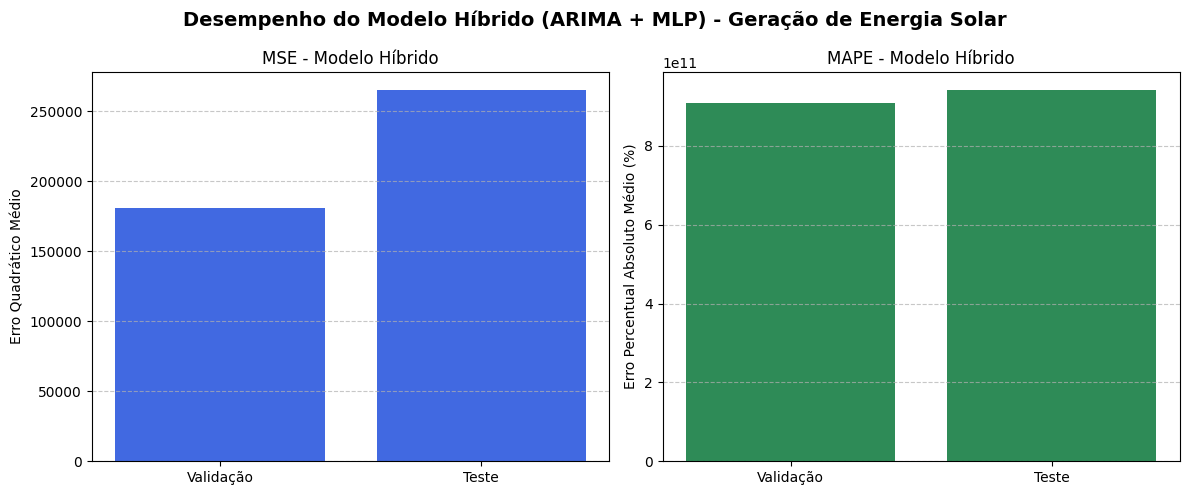

In [10]:
stages = ["Validação", "Teste"]
mse_scores = [mse(y_val[-val_len:], hyb_val_pred), mse(y_test[-test_len:], hyb_test_pred)]
mape_scores = [mape(y_val[-val_len:], hyb_val_pred), mape(y_test[-test_len:], hyb_test_pred)]

# Criar figura com 2 subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# --- Gráfico do MSE ---
axes[0].bar(stages, mse_scores, color="royalblue")
axes[0].set_title("MSE - Modelo Híbrido")
axes[0].set_ylabel("Erro Quadrático Médio")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# --- Gráfico do MAPE ---
axes[1].bar(stages, mape_scores, color="seagreen")
axes[1].set_title("MAPE - Modelo Híbrido")
axes[1].set_ylabel("Erro Percentual Absoluto Médio (%)")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Título geral
fig.suptitle("Desempenho do Modelo Híbrido (ARIMA + MLP) - Geração de Energia Solar", fontsize=14, fontweight="bold")

plt.tight_layout()
plt.savefig(OUTPUT / "Hibrido - Desempenho do Modelo Híbrido (ARIMA + MLP).png")
plt.show()

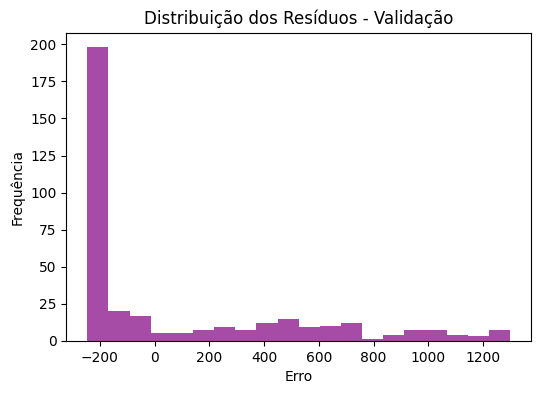

In [11]:
residuos_val = y_val[-len(hyb_val_pred):] - hyb_val_pred

plt.figure(figsize=(6,4))
plt.hist(residuos_val, bins=20, color="purple", alpha=0.7)
plt.title("Distribuição dos Resíduos - Validação")
plt.xlabel("Erro")
plt.ylabel("Frequência")
plt.savefig(OUTPUT / "Hibrido - Distribuição dos Resíduos - Validação.png")
plt.show()

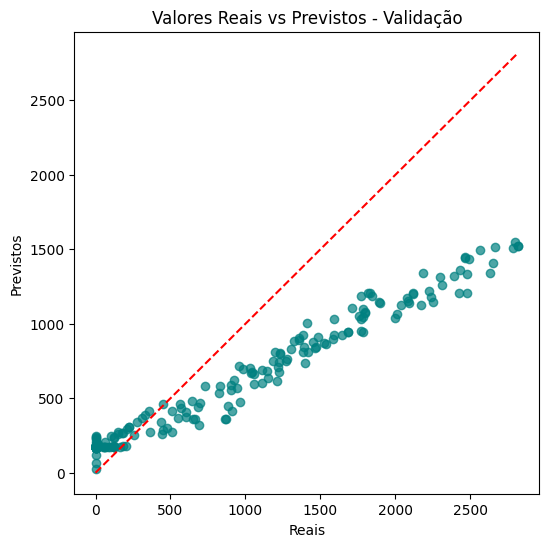

In [12]:
plt.figure(figsize=(6,6))
plt.scatter(y_val[-len(hyb_val_pred):], hyb_val_pred, alpha=0.7, color="teal")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--")  # linha ideal
plt.title("Valores Reais vs Previstos - Validação")
plt.xlabel("Reais")
plt.ylabel("Previstos")
plt.savefig(OUTPUT / 'Hibrido - Valores Reais vs Previstos - Validação.png')
plt.show()